# GDS Assignment 2 - Rasmus Dübeck Kristensen

# Part 1
Generate a full clean dataset (notice: last assignment I only generated the 'conent' column, not the full set). Therefore I have included this excerpt from assignment 1: 

In [23]:
import pandas as pd
import re

# Load the data
data = pd.read_csv("news_sample.csv")

# Compile regex patterns
date_regex = re.compile(r"""
\b(
    (?:\d{1,2}[./-]\d{1,2}[./-]\d{2,4}) | # 01/01/2025, 1.1.2025, 1-1-25
    (?:\d{4}[./-]\d{1,2}[./-]\d{1,2}) | # 2025/01/01, 2025-1-1
    (?:\b(?:\d{1,2})(?:st|nd|rd|th)?\s+(?:of\s+)?[A-Za-z]+\s+\d{4}\b) |  # 1st January 2025, 2nd of February 2024
    (?:\b[A-Za-z]+\s+(?:\d{1,2})(?:st|nd|rd|th)?,?\s+\d{4}\b) | # January 1st 2025, March 2nd, 2023
    (?:\b[A-Za-z]+\s+\d{4}\b) # January 2025, March 2024
)\b
""", re.VERBOSE | re.IGNORECASE)

number_regex = re.compile(r'(\d+)')
email_regex = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
url_regex = re.compile(r'\b(?:http[s]?://|www\.)[^\s<>"]+|www\.[^\s<>"]+\b')
whitespace_regex = re.compile(r'\s+')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(whitespace_regex, ' ', text) # Replace multiple whitespace with a single space
    text = re.sub(date_regex, "<DATE>", text)
    text = re.sub(url_regex, "<URL>", text)
    text = re.sub(email_regex, "<EMAIL>", text)
    text = re.sub(number_regex, "<NUM>", text)
    return text.strip()

# Clean all columns in the dataframe
for column in data.columns:
    if data[column].dtype == 'object':  # Only clean text columns
        data[column] = data[column].apply(clean_text)

# Save cleaned data to a new CSV file
data.to_csv("cleaned_news_sample.csv", index=False)

print("Cleaning complete! Data saved to cleaned_news_sample.csv.")

Cleaning complete! Data saved to cleaned_news_sample.csv.


Import full dataset: 

In [24]:
cleaned_data = pd.read_csv('cleaned_news_sample.csv')


## Part 1 - import clean dataset + dataset analyis

Article types that should certainly be omitted: "unknown" and "missing value" since they aren't categorized. 

Group the remaining types into 'fake' and 'reliable':

- hate: should be grouped 'fake' since it actively promotes racism, homophobia and other forms of discrimination, which is clearly not chracteristic of reliable media

- conspiracy: 'fake' 

- clickbait: 'reliable' since the content is generally credible in spite of exaggerating headlines 

- bias: 'fake'. Labeled as 'extreme bias' and containing "opinions distorted as facts" in the ReadMe

- political: 'reliable' since it is generally credible

- junksci:  'fake' since it contains sources that promote 'pseudoscience, naturalistic fallacies, and other scientifically dubious claims'.

The dataset is not balanced. Only a few (3 out of 244) articles are "reliable" (24 if we include "clickbait" and "political"). 

Discuss the importance of a balanced distribution: This dataset doesn't seem representative of the actual diversity of information sources and could lead to biased conclusions. A dataset with a disproportionate number of unreliable or biased entries may over-represent certain viewpoints while under-representing others, leading to skewed results in any analysis or model built from the data. For instance, if the majority of articles are unreliable, any machine learning model trained on this data might learn to perpetuate unreliable patterns, thus affecting its generalization and predictive accuracy. A balanced distribution, where each category (reliable vs. unreliable) is properly represented, is crucial for ensuring that the analysis reflects a more accurate and fair representation of the real-world scenario.

Here is a plot of the skewed distribution of types:

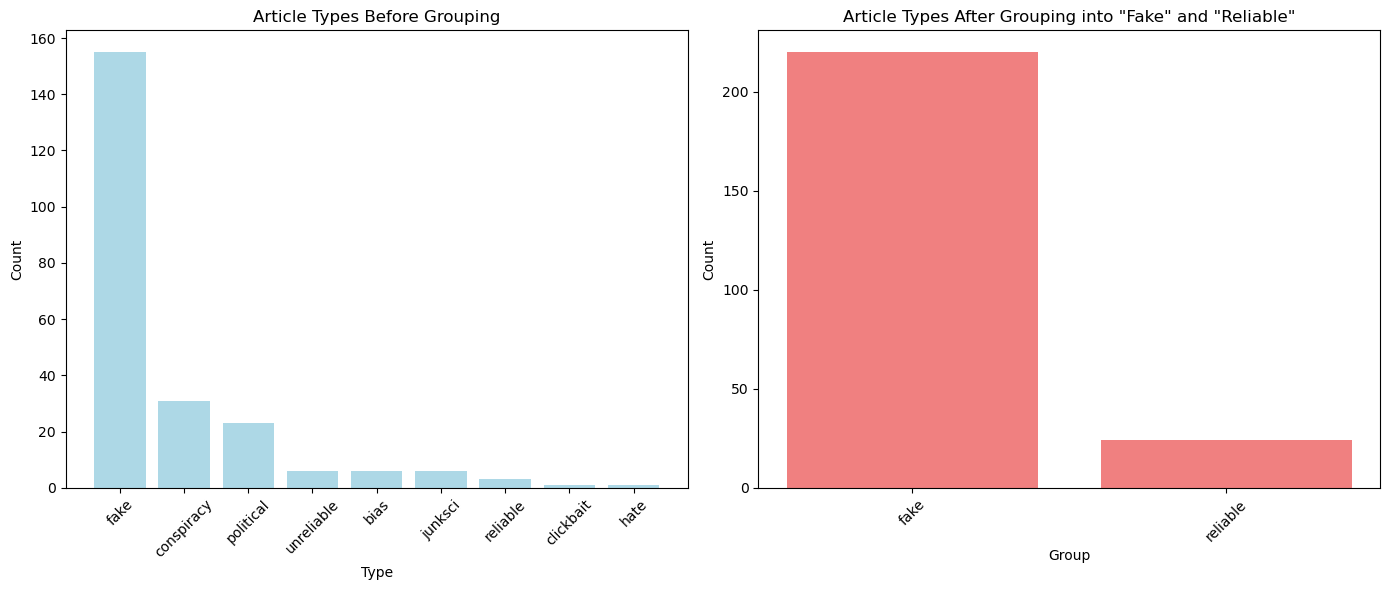

grouped_type
fake        220
reliable     24
Name: count, dtype: int64


In [30]:
import matplotlib.pyplot as plt

# Load the dataset
data = cleaned_data

# Define a mapping for types to "fake" and "reliable"
type_mapping = {
    'hate': 'fake',
    'conspiracy': 'fake',
    'clickbait': 'reliable',
    'bias': 'fake',
    'political': 'reliable',
    'junksci': 'fake',
    # Add any other types here as needed
}

# Filter out "unknown" and "missing value" and create a copy
filtered_data = data[~data['type'].isin(['unknown', 'missing value'])].copy()

# Apply the type mapping to create a new 'grouped_type' column
filtered_data['grouped_type'] = filtered_data['type'].map(type_mapping).fillna('fake')

# Count the occurrences of each type before grouping
before_grouping = filtered_data['type'].value_counts()

# Apply the type mapping to create a new 'grouped_type' column
filtered_data['grouped_type'] = filtered_data['type'].map(type_mapping).fillna('fake')

# Count the occurrences of 'fake' and 'reliable' after grouping
after_grouping = filtered_data['grouped_type'].value_counts()

# Plot the data
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot before grouping
ax[0].bar(before_grouping.index, before_grouping.values, color='lightblue')
ax[0].set_title('Article Types Before Grouping')
ax[0].set_xlabel('Type')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=45)

# Plot after grouping
ax[1].bar(after_grouping.index, after_grouping.values, color='lightcoral')
ax[1].set_title('Article Types After Grouping into "Fake" and "Reliable"')
ax[1].set_xlabel('Group')
ax[1].set_ylabel('Count')
ax[1].tick_params(axis='x', rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Optionally, print out the mapping result to debug
print(after_grouping)



# Part 2

Remember to accept cookies manually!

In [ ]:
import csv
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException

# List of URLs to scrape
urls = [
    'https://www.bbc.com/news/world/europe',
    'https://www.bbc.com/news/us-canada',
    'https://www.bbc.com/news/uk',
    'https://www.bbc.com/news/world/australia',
    'https://www.bbc.com/news/world/africa',
    'https://www.bbc.com/news/world/asia',
    'https://www.bbc.com/news/world/latin_america',
    'https://www.bbc.com/news/world/middle_east'
]

# Start webdriver
browser = webdriver.Firefox()
browser.get(urls[0])

# Remember to accept cookies manually!
input("Notice! Make sure to manually agree to cookies twice before pressing enter...")

# Funktion til at finde antal sider
def get_button_text(browser):
    try:
        button = WebDriverWait(browser, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "button.sc-944f9211-1:nth-child(8)"))
        )
        return int(button.text)
    except (TimeoutException, StaleElementReferenceException) as e:
        print(f"Error: button not found{e}")
        return 1  # Default to 1 page

# Scraping function
def scrape(url, browser):
    articles = {}
    
    # Find number of pages
    num_pages = get_button_text(browser)

    for page in range(num_pages):
        # Find all article-containere
        all_articles = browser.find_elements(By.CSS_SELECTOR, "div[data-testid='dundee-card'], div[data-testid='liverpool-card']")
        
        # Iterate through each article and extract 
        for article in all_articles:
            # Get h2 (headline)
            h2_element = article.find_elements(By.CSS_SELECTOR, "h2[data-testid='card-headline']")
            h2 = h2_element[0].text.strip() if h2_element else ""
            
            # Get summary
            summary_element = article.find_elements(By.CSS_SELECTOR, "p[data-testid='card-description']")
            summary = summary_element[0].text.strip() if summary_element else ""
            
            # Get link (URL)
            link_element = article.find_elements(By.CSS_SELECTOR, "a[data-testid='internal-link']")
            article_link = link_element[0].get_attribute("href") if link_element else ""
            
            # Save only articles with headline and description
            if h2 and summary and article_link:
                if article_link in articles:
                    existing_article = articles[article_link]
                    existing_fields = sum(1 for value in existing_article.values() if value)
                    new_fields = sum(1 for value in [h2, summary, article_link] if value)
                    
                    if new_fields > existing_fields:
                        articles[article_link] = {'h2': h2, 'summary': summary}
                else:
                    articles[article_link] = {'h2': h2, 'summary': summary}

        # Click "next" button, if possible
        try:
            button = WebDriverWait(browser, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[data-testid='pagination-next-button']")))
            button.click()
        except TimeoutException:
            print(f"No 'Next' button found on page {page + 1} of {url}. Stopping.")
            break
    
    return articles

# Loop for each URL
all_articles_data = {}

for url in urls:
    browser.get(url)
    articles = scrape(url, browser)
    all_articles_data.update(articles)

# Number of articles found
valid_article_count = len(all_articles_data)
print(f"Total number of articles with headline and summary: {valid_article_count}")

# Close browser
browser.quit()

# Save to CSV
with open('bbc_articles.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Headline", "Summary", "URL"]) 
    
    for article_url, article in all_articles_data.items():
        writer.writerow([article["h2"], article["summary"], article_url])

print("Scraping complete! Data saved to bbc_articles.csv.")



No 'Next' button found on page 12 of https://www.bbc.com/news/world/europe. Stopping.
No 'Next' button found on page 12 of https://www.bbc.com/news/us-canada. Stopping.
No 'Next' button found on page 12 of https://www.bbc.com/news/uk. Stopping.
No 'Next' button found on page 12 of https://www.bbc.com/news/world/australia. Stopping.
No 'Next' button found on page 12 of https://www.bbc.com/news/world/africa. Stopping.
No 'Next' button found on page 12 of https://www.bbc.com/news/world/asia. Stopping.
No 'Next' button found on page 12 of https://www.bbc.com/news/world/latin_america. Stopping.
No 'Next' button found on page 11 of https://www.bbc.com/news/world/middle_east. Stopping.
Total number of articles with headline and summary: 848
Scraping complete! Data saved to bbc_articles.csv.


# Part 3

In [27]:
import time
from datetime import datetime

def text_scrape(url, browser):
    try:
        print(f"Scraping: {url}")  
        browser.get(url)

        # Headline
        headline_element = WebDriverWait(browser, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "h1"))
        )
        headline = headline_element.text.strip()

        # Article Text
        text_element = browser.find_elements(By.CSS_SELECTOR, 
                        "div.sc-18fde0d6-0.dlWCEZ[data-component='text-block'], "
                        "div.ssrcss-7uxr49-RichTextContainer.e5tfeyi1"
                    )
        text = " ".join([p.text for p in text_element])

        # Published Date
        published_date_element = browser.find_elements(By.CSS_SELECTOR, "time")
        published_date_raw = published_date_element[0].get_attribute("datetime") if published_date_element else "Unknown"
        if published_date_raw != "Unknown":
            published_date = datetime.fromisoformat(published_date_raw.replace("Z", "")).strftime("%Y-%m-%d %H:%M:%S")
        else:
            published_date = "Unknown"

        # Fix for multiple authors
        author_elements = browser.find_elements(By.CSS_SELECTOR, "span.sc-b42e7a8f-7.kItaYD")
        authors = [element.text.strip() for element in author_elements if element.text.strip()]
        author = ", ".join(authors) if authors else "Unknown"

        return {
            'url': url,
            'headline': headline,
            'text': text,
            'published_date': published_date,
            'author': author
        }
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None


def read_urls_from_csv(file_name):
    urls = []
    with open(file_name, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            urls.append(row['URL'])
    return urls

def scrape_all_articles(urls, browser):
    articles = []
    
    for url in urls:
        article_data = text_scrape(url, browser)
        if article_data:
            articles.append(article_data)
        time.sleep(2)  # Adding delay to avoid being blocked

    return articles

# Start browser
browser = webdriver.Firefox()

# Read URLs from CSV file
urls = read_urls_from_csv("bbc_articles.csv")

# Scrape articles
scraped_data = scrape_all_articles(urls, browser)

# Close browser
browser.quit()

# Save to CSV
with open('scraped_articles_text_headline_date_author.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["URL", "Headline", "Text", "Published Date", "Author"])

    for article in scraped_data:
        writer.writerow([article["url"], article["headline"], article["text"], article["published_date"], article["author"]])

print("Scraping complete! Data saved to scraped_articles_text_headline_date_author.csv.")



Scraping: https://www.bbc.com/news/articles/cy9dp5rr2x9o
Scraping: https://www.bbc.com/news/articles/cy87vg38dnpo
Scraping: https://www.bbc.com/news/articles/c62k0kxwzywo
Scraping: https://www.bbc.com/news/articles/c3w195pgp40o
Scraping: https://www.bbc.com/news/articles/crknjxj3n4zo
Scraping: https://www.bbc.com/news/articles/cqjd78jpqj9o
Scraping: https://www.bbc.com/news/articles/c0rz0jvvpwwo
Scraping: https://www.bbc.com/news/articles/c1kjwmzvg23o
Scraping: https://www.bbc.com/news/articles/cy83r93l208o
Scraping: https://www.bbc.com/news/articles/crmjewpkje9o
Scraping: https://www.bbc.com/news/articles/c627685p21eo
Scraping: https://www.bbc.com/news/articles/c17qnxrq1y7o
Scraping: https://www.bbc.com/news/articles/czedpnen168o
Scraping: https://www.bbc.com/news/articles/cz7v1ejv01go
Scraping: https://www.bbc.com/news/videos/cd65nl7n6y9o
Scraping: https://www.bbc.com/news/videos/c798q33r9gjo
Scraping: https://www.bbc.com/news/videos/cvgw91rvn8xo
Scraping: https://www.bbc.com/news/vi

I seem to get an error with around 15 BBC Australia articles that specifically link to BBC Sport (for some reason it seems that only BBC Australia does this), which uses a different source code than the rest of the BBC’s website. 
I did not have time to mitigate the issue, but I believe it could be solved by adding extra CSS_SELECTOR codes that work with the BBC.com/Sport website as well the rest of the website. 

Discussion: Discuss whether it would make sense to include this newly acquired data in the dataset. Argue why or why not and if possible include statistics to support your claim.

Text: A very relevant data point, as it could be used for analyzing language and discourse patterns within news articles. This could be especially useful when comparing mainstream media with misinformation or fake news sources, identifying recurring themes, stylistic differences, or emotional tone. On the other hand, the text parameter is fairly long, so analyzing it might take a lot of resources compared to if we simply analyze summaries or 'content'.

Headline: A crucial parameter, which should identify the main content of the article and potential clickbait. 

Published date: Could also be useful since current affairs evolve rapidly, and the timing of an article’s publication can influence its impact. For instance, analyzing the frequency and timing of certain narratives could help track how news cycles develop over time. However, at the time of writing that seems a little out of scope for this course. 

Authors: If we consider only the BBC as a source, I think it would be redundant to include authors as a data point since we can be pretty sure that all articles from the BBC are reliable, regardless of the author. For other sources, namely Fake News website, political websites or biased website, it might be more relevant, since some outlets are more open to letting e.g. conspiracy theorists contribute. All in all, it could be a relevant datapoint, depending on our goals. 